The bit below was copied from the starting points blog post, basically sets us up for where we were last time.  You might recall that I ran through what we'd done before as kind of a review first.

In [1]:
import nltk
vfs = nltk.Valuation.fromstring
dom = {'a', 'b', 'c', 'd', 'm', 's'}
names = """
andrea => a
bobby => b
chris => c
dana => d
the_sun => s
the_moon => m
"""
val = vfs(names)
val.update(vfs("person => {a, b, c, d}"))
val.update(vfs("spaceball => {s, m}"))
val.update(vfs("bostonian => {a, b}"))
val.update(vfs("cantabrigian => {c, d}"))

Chris likes the moon.

In [2]:
val.update(vfs("likes => {(c,m)}"))

Updating the value of 'likes' to include the information that Bobby likes Andrea and Dana likes Chris (but without forgetting the information that Chris likes the moon).  The thing to notice here is that you are asking the value of 'likes' to update itself, rather that asking the valuation function to update its value for 'likes' (which would have just replaced 'likes' and forgotten about Chris and the moon).

In [3]:
val['likes'].update({('b','a'), ('d', 'c')})

In [4]:
val['likes']

{('b', 'a'), ('c', 'm'), ('d', 'c')}

Andrea likes everyone. How to encode this? Well, we can go through all the people (`for (p,) in val['person']`) and update the value of 'likes' to include the pair of andrea (`'a'`) and the current person.

In [5]:
for (p,) in val['person']:
    val['likes'].update({('a', p)})

In [6]:
val['likes']

{('a', 'a'),
 ('a', 'b'),
 ('a', 'c'),
 ('a', 'd'),
 ('b', 'a'),
 ('c', 'm'),
 ('d', 'c')}

Everyone likes Dana.

In [7]:
for (p,) in val['person']:
    val['likes'].update({(p, 'd')})

In [8]:
val['likes']

{('a', 'a'),
 ('a', 'b'),
 ('a', 'c'),
 ('a', 'd'),
 ('b', 'a'),
 ('b', 'd'),
 ('c', 'd'),
 ('c', 'm'),
 ('d', 'c'),
 ('d', 'd')}

Now, set up a model (which provides us with the ability to evaluate expressions against the model).  To specify a model, we need to specify the domain of individuals and the valuation function.

In [9]:
m = nltk.Model(dom, val)

We also need to define an assignment, which is more or less what we're pointing to in that model of the world we just defined. It's necessary for determining, for example, what a pronoun refers to.  (We can't evaluate whether "I saw him" is true or false until we know who you are pointing at, even if we know who all the people are and what their properties are.)  We are not really going to use this for much of anything, but we still need to define an assignment.  One does so like this:

In [10]:
g = nltk.Assignment(dom)

Now that we have a model and an assignment, we can ask the model to evaluate the expression `likes(dana, chris)` and it can do this.  It will say `True`.  Because we specifed that.  It will also say true for `likes(chris, dana)` because, well, everyone likes Dana.  It knows how to evaluate the expression because the valuation function has definitions for `dana` and `chris` and `likes`.

In [11]:
print(m.evaluate('likes(dana, chris)', g))

True


In [12]:
print(m.evaluate('likes(chris, dana)', g))

True


The expressions can be more complex as well.  This will evaluate "Andrea likes everyone."  The form here is a little bit complex, though I've now gone over it in class twice.  The expression evaluation knows how to evaluate `all x.`, which it does by going through the domain of individuals that we gave it, and checking to see if the part after the `.` is true if we substitute in the curent individual for `x`.  Then, if all of these tests yield `True`, then the whole expression is true.  What it is testing is "being a person entails being someone Andrea likes".  Some of the individuals in the domain of individuals are not people (such as the moon), and we don't care whether Andrea likes the moon.  It won't affect whether "Andrea likes everyone" is true.  But if the current x is a person, then the pair (andrea, x) must be in the set of likings.

In [13]:
print(m.evaluate('all x.(person(x) -> likes(andrea, x))', g))

True


You can define expressions without evaluating them.  To do that, we'll create a shortcut here by naming `nltk.sem.Expression.fromsting` as `sfs`.  This is the same trick we did before when defining `vfs`.  I guess I had "semantics from string" or something in mind when I named it.

In [14]:
sfs = nltk.sem.Expression.fromstring

Once we have `sfs` defined, we can use that to define an expression for "likes(x, bobby)".

In [15]:
f1 = sfs('likes(x, bobby)')

In [16]:
print(f1)

likes(x,bobby)


In [17]:
type(f1)

nltk.sem.logic.ApplicationExpression

When we have an expression, we can inquire of it what variables are within it that lack a value.  This is essentially asking what we need to know in order to decide whether the expession is true.  This expression says someone X likes Bobby, and so if we knew X, we could determine whether the expression is true in this model of the world.  The `.free()` function will tell us what it needs.

In [18]:
print(f1.free())

{Variable('x')}


We can then ask the model to tell us which values for `x` would make this expression true.  These are the `.satisfiers()`.  We need to give it the expression (`f1`), the variable that we're testing (`x`, meaning that we want the model to go through the domain of individuals and try replacing `x` with each of them in turn, to see which of them make it true), and the pointing function.  We discover that the only one who is a Bobby-liker in this model of the world is Andrea.

In [19]:
print(m.satisfiers(f1, 'x', g))

{'a'}


Ok, now we're building a little grammar.  The following was copied and pasted from the starting points blog post, it defines the NP nodes along with a feature that corresponds to their semantics.  So, if 'andrea' is the English word, the node above it is an NP that has the semantic value `<andrea>`.  We will be using this to build up the grammar so we can parse a sentence.

In [20]:
npdef = """
NP[SEM=<andrea>] -> 'andrea'
NP[SEM=<bobby>] -> 'bobby'
NP[SEM=<chris>] -> 'chris'
NP[SEM=<dana>] -> 'dana'
NP[SEM=<the_sun>] -> 'the_sun'
NP[SEM=<the_moon>] -> 'the_moon'
"""

For no good reason, I called this `cfg` rather than `cfgdef`, so it isn't parallel to what's above, but we can start off the context free grammar definition at the top with S, the sentence.  And S is made of NP and a VP.  We have defined NP above, and we'll define VP next.  But when we have a VP and an NP, the semantic value of the S that contains the two will be the function defined by the semantic value of the VP applied to the argument defined by the semantic value of the NP subject.  So, if the VP is "swims" its semantic value will be `\x.swims(x)`, which is a function that takes an individual as an argument (calling it x) and returns True if x swims.  And the semantic value of the subject is an individual.  So the way we write the semantic value of the overall S is a function applied to an argument.  The `?vp` notation means "the value, which we will refer to henceforth as `?vp`".  So, the S line below names the semantic value of the VP `?vp` and the semantic value of the subject NP `?subj`, and then sets the semantic value of the overall S to be `?vp(?subj)`, or, the VP function applied to the NP subject.

In [21]:
cfg = r"""
% start S
S[SEM=<?vp(?subj)>] -> NP[SEM=?subj ] VP[SEM=?vp ]
"""

As foreshadowed, the definition of VP is next.  This is the definition for "likes", and it is one step more complex than "swims" because "like" is transitive.  So, the VP contains a V and an object.  The object has the same kind of semantics as the subject did.  We'll call it `?obj`.  The transitive verb is a function that takes an individual (the object) and returns a property-type function.  For example, if the object were "the_moon", then "likes" combines with "the_moon" and returns the property of "likes the moon."  That, "likes the moon", is now the same kind of thing as "swims": it is a function that takes an individual as an argument and will return True if that individual likes the moon.  This is probably a bit complex if you haven't seen it before now, but I think if you think it through slowly it will make sense.  And there is a bit in the book about it as well.

In [22]:
cfg += r"""
VP[SEM=<?v(?obj)>] -> V[SEM=?v] NP[SEM=?obj]
V[SEM=<\y.\x.likes(x,y)>] -> 'likes'
"""

Now, add in the NP definitions as well

In [23]:
cfg += npdef

In [24]:
print(cfg)


% start S
S[SEM=<?vp(?subj)>] -> NP[SEM=?subj ] VP[SEM=?vp ]

VP[SEM=<?v(?obj)>] -> V[SEM=?v] NP[SEM=?obj]
V[SEM=<\y.\x.likes(x,y)>] -> 'likes'

NP[SEM=<andrea>] -> 'andrea'
NP[SEM=<bobby>] -> 'bobby'
NP[SEM=<chris>] -> 'chris'
NP[SEM=<dana>] -> 'dana'
NP[SEM=<the_sun>] -> 'the_sun'
NP[SEM=<the_moon>] -> 'the_moon'



And now we can use the text description in `cfg` to actually build up a grammar we can use to parse a tree and evaluate semantics with.

In [25]:
from nltk import grammar

In [26]:
gram = grammar.FeatureGrammar.fromstring(cfg)

In [27]:
cp = nltk.FeatureChartParser(gram)

In [28]:
sent = 'bobby likes chris'

In [29]:
words = sent.split()

In [30]:
words

['bobby', 'likes', 'chris']

In [31]:
parses = list(cp.parse(words))

In [32]:
print(len(parses))

1


In [33]:
print(parses[0])

(S[SEM=<likes(bobby,chris)>]
  (NP[SEM=<bobby>] bobby)
  (VP[SEM=<\x.likes(x,chris)>]
    (V[SEM=<\y x.likes(x,y)>] likes)
    (NP[SEM=<chris>] chris)))


For me, if I just display the value of `parses[0]` I get a little image displayed.  Not a beautiful one, but it's ok.  I think when you first open this notebook you'll be able to see it, but if you re-reun the commands in the notebook it will crash out unless you've installed... something.  I'm not sure what it is that this relies on.  So, I'm going to "comment out" the line below, in order to ensure that you can re-run this notebook and get it to work.

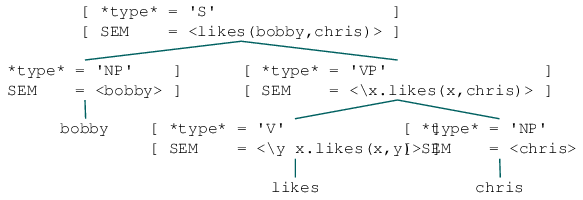

In [34]:
#parses[0]

To get the semantic value of the node a the top of the tree (the label of the parse), retrieve the value for the key `SEM`, like so:

In [35]:
treesem = parses[0].label()['SEM']

In [36]:
print(treesem)

likes(bobby,chris)


In [37]:
type(treesem)

nltk.sem.logic.ApplicationExpression

So, this tree is "Bobby likes Chris."  Is that... true?

In [38]:
print(m.satisfy(treesem, g))

False


Just to show that this will tell us something true if we give it something true, we can evaluate whether Chris likes Dana in this same way.

In [39]:
print(m.satisfy(sfs("likes(chris,dana)"), g))

True


For the rest of the class we kind of moved on to looking at SHRDLU and starting to set that up.  The homework will kind of pick up here, though, and walk you through a more complex set of steps.  Also, there will be some review in the write-up for the homework of what was going on above.